# Breast Cancer Segmentation using Transformers

In [ ]:
!pip install kaggle
!pip install transformers
!pip install datasets
!pip install evaluate

In [ ]:
# อัพโหลด kaggle.json ที่หาได้จาก https://www.kaggle.com/settings (ไปที่หน้านี้แล้วกด "Create New Token" ใน section API)
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset
!unzip breast-ultrasound-images-dataset.zip

In [6]:
from transformers import SegformerForSemanticSegmentation
from transformers import SegformerFeatureExtractor
from transformers import TrainingArguments, Trainer
from torchvision.transforms import ColorJitter, Resize, Compose

import torch
from torch import nn
import evaluate
import datasets
from datasets import Dataset, Features
import numpy as np

import os.path as op
from glob import glob
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm
import os

In [11]:
paths = glob("Dataset_BUSI_with_GT/*/*")
im_paths = [path for path in paths if "_mask" not in path]
data_paths = []

for path in im_paths:
    class_name = Path(path).parent.name
    seg_path = Path(Path(path).parent, Path(path).stem + "_mask.png")
    if op.exists(seg_path):
        data_paths.append({
            "img": path,
            "seg": str(seg_path),
            "class": class_name
        })
print("Length of image and segmentation paths = ", len(data_paths))

Length of image and segmentation paths =  780


In [12]:
data_paths = {
    "img": [p["img"] for p in data_paths],
    "seg": [p["seg"] for p in data_paths],
    "class": [p["class"] for p in data_paths]
}
id2label = {0:"background", 1: "benign", 2: "malignant"}
label2id = {v: k for k, v in id2label.items()}

In [15]:
ds = Dataset.from_dict(data_paths, features=Features(
    {"img": datasets.Image(),
     "seg": datasets.Image(),
     "class": datasets.Value(dtype='string', id=None)}))
ds_split = ds.train_test_split(test_size=0.2)

In [16]:
train_ds = ds_split["train"]
test_ds = ds_split["test"]

In [8]:
feature_extractor = SegformerFeatureExtractor()

_transforms = Compose([
    ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1),
])

c:\Users\USER\anaconda3\lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


In [ ]:
def train_transforms(example_batch):
    images = [_transforms(x) for x in example_batch["img"]]
    labels = []
    for segim, cls in zip(example_batch["seg"], example_batch["class"]):
        segim = np.array(segim).astype(int)
        if cls == "benign":
          segim[segim == 1] = 1
        elif cls == "malignant":
          segim[segim == 1] = 2
        else:
          pass
        if len(segim.shape) == 3:
          segim = segim[:, :, 0]
        labels.append(segim)
    inputs = feature_extractor(images, labels)
    return inputs

def val_transforms(example_batch):
    images = [x for x in example_batch["img"]]
    labels = []
    for segim, cls in zip(example_batch["seg"], example_batch["class"]):
        segim = np.array(segim).astype(int)
        if cls == "benign":
          segim[segim == 1] = 1
        elif cls == "malignant":
          segim[segim == 1] = 2
        else:
          pass
        if len(segim.shape) == 3:
          segim = segim[:, :, 0]
        labels.append(segim)
    inputs = feature_extractor(images, labels)
    return inputs

In [ ]:
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

In [ ]:
num_labels = len(id2label)

metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics = metric.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=num_labels,
            ignore_index=255,
            reduce_labels=False,
        )
        for key, value in metrics.items():
            if type(value) is np.ndarray:
                metrics[key] = value.tolist()
        return metrics

In [ ]:
pretrained_model_name = "nvidia/mit-b0" 
model = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name,
    id2label=id2label,
    label2id=label2id
)

In [4]:
save_path = "segformer-breast-cancer_30ep"

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

n_epochs = 30

training_args = TrainingArguments(
    output_dir= save_path,
    learning_rate=6e-5,
    num_train_epochs=n_epochs,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=300,
    eval_steps=300,
    logging_steps=1,
    eval_accumulation_steps=5,
    remove_unused_columns=False,
    push_to_hub=False,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

trainer.train()
feature_extractor.save_pretrained(save_path)

## Inference

In [13]:
model_path = f"{save_path}/checkpoint-1500/" 
image_processor = feature_extractor.from_pretrained(f"{model_path}/preprocessor_config.json", local_files_only=True) 
model = SegformerForSemanticSegmentation.from_pretrained(f"{model_path}",id2label=id2label, label2id=label2id, local_files_only=True)  

In [18]:
train_ds

Dataset({
    features: ['img', 'seg', 'class'],
    num_rows: 624
})

<Figure size 432x288 with 0 Axes>

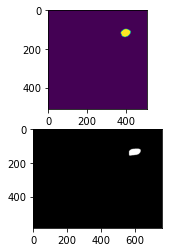

In [24]:
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

image = train_ds[22]['img']
gt_seg = train_ds[22]['seg']

inputs = feature_extractor(images=image, return_tensors="pt", )
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

upsampled_logits = nn.functional.interpolate(
    logits,
    size=(512,512),
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]

plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(2,1) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(pred_seg)
axarr[1].imshow(gt_seg, cmap='gray')

In [25]:
image = Image.open("./Dataset_BUSI_with_GT/benign/benign (1).png")
gt = Image.open("./Dataset_BUSI_with_GT/benign/benign (1)_mask.png")

In [26]:
from transformers import pipeline

segmenter = pipeline("image-segmentation", model=model_path)
segmenter(image)

[{'score': None,
  'label': 'background',
  'mask': <PIL.Image.Image image mode=L size=562x471>},
 {'score': None,
  'label': 'benign',
  'mask': <PIL.Image.Image image mode=L size=562x471>}]

In [27]:
encoding = feature_extractor(image, return_tensors="pt")
pixel_values = encoding.pixel_values

In [28]:
outputs = model(pixel_values=pixel_values)
logits = outputs.logits.cpu()

In [29]:
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]

In [30]:
def ade_palette():
  """Creates a label colormap used in ADE20K segmentation benchmark.
  Returns:
    A colormap for visualizing segmentation results.
  """
  return np.asarray([
      [0, 0, 0],
      [120, 120, 120],
      [180, 120, 120],
      [6, 230, 230],
      [80, 50, 50],
      [4, 200, 3],
      [120, 120, 80],
      [140, 140, 140],
      [204, 5, 255],
      [230, 230, 230],
      [4, 250, 7],
      [224, 5, 255],
      [235, 255, 7],
      [150, 5, 61],
      [120, 120, 70],
      [8, 255, 51],
      [255, 6, 82],
      [143, 255, 140],
      [204, 255, 4],
      [255, 51, 7],
      [204, 70, 3],
      [0, 102, 200],
      [61, 230, 250],
      [255, 6, 51],
      [11, 102, 255],
      [255, 7, 71],
      [255, 9, 224],
      [9, 7, 230],
      [220, 220, 220],
      [255, 9, 92],
      [112, 9, 255],
      [8, 255, 214],
      [7, 255, 224],
      [255, 184, 6],
      [10, 255, 71],
      [255, 41, 10],
      [7, 255, 255],
      [224, 255, 8],
      [102, 8, 255],
      [255, 61, 6],
      [255, 194, 7],
      [255, 122, 8],
      [0, 255, 20],
      [255, 8, 41],
      [255, 5, 153],
      [6, 51, 255],
      [235, 12, 255],
      [160, 150, 20],
      [0, 163, 255],
      [140, 140, 140],
      [250, 10, 15],
      [20, 255, 0],
      [31, 255, 0],
      [255, 31, 0],
      [255, 224, 0],
      [153, 255, 0],
      [0, 0, 255],
      [255, 71, 0],
      [0, 235, 255],
      [0, 173, 255],
      [31, 0, 255],
      [11, 200, 200],
      [255, 82, 0],
      [0, 255, 245],
      [0, 61, 255],
      [0, 255, 112],
      [0, 255, 133],
      [255, 0, 0],
      [255, 163, 0],
      [255, 102, 0],
      [194, 255, 0],
      [0, 143, 255],
      [51, 255, 0],
      [0, 82, 255],
      [0, 255, 41],
      [0, 255, 173],
      [10, 0, 255],
      [173, 255, 0],
      [0, 255, 153],
      [255, 92, 0],
      [255, 0, 255],
      [255, 0, 245],
      [255, 0, 102],
      [255, 173, 0],
      [255, 0, 20],
      [255, 184, 184],
      [0, 31, 255],
      [0, 255, 61],
      [0, 71, 255],
      [255, 0, 204],
      [0, 255, 194],
      [0, 255, 82],
      [0, 10, 255],
      [0, 112, 255],
      [51, 0, 255],
      [0, 194, 255],
      [0, 122, 255],
      [0, 255, 163],
      [255, 153, 0],
      [0, 255, 10],
      [255, 112, 0],
      [143, 255, 0],
      [82, 0, 255],
      [163, 255, 0],
      [255, 235, 0],
      [8, 184, 170],
      [133, 0, 255],
      [0, 255, 92],
      [184, 0, 255],
      [255, 0, 31],
      [0, 184, 255],
      [0, 214, 255],
      [255, 0, 112],
      [92, 255, 0],
      [0, 224, 255],
      [112, 224, 255],
      [70, 184, 160],
      [163, 0, 255],
      [153, 0, 255],
      [71, 255, 0],
      [255, 0, 163],
      [255, 204, 0],
      [255, 0, 143],
      [0, 255, 235],
      [133, 255, 0],
      [255, 0, 235],
      [245, 0, 255],
      [255, 0, 122],
      [255, 245, 0],
      [10, 190, 212],
      [214, 255, 0],
      [0, 204, 255],
      [20, 0, 255],
      [255, 255, 0],
      [0, 153, 255],
      [0, 41, 255],
      [0, 255, 204],
      [41, 0, 255],
      [41, 255, 0],
      [173, 0, 255],
      [0, 245, 255],
      [71, 0, 255],
      [122, 0, 255],
      [0, 255, 184],
      [0, 92, 255],
      [184, 255, 0],
      [0, 133, 255],
      [255, 214, 0],
      [25, 194, 194],
      [102, 255, 0],
      [92, 0, 255],
  ])

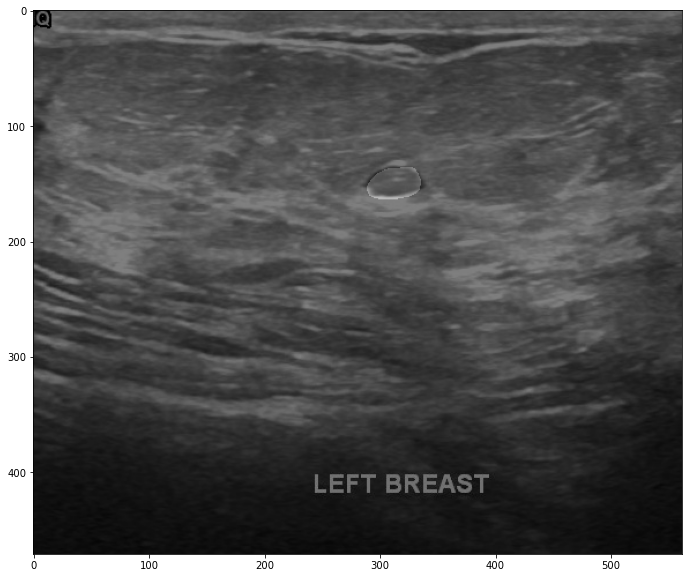

In [31]:
import matplotlib.pyplot as plt
import numpy as np

color_seg = np.zeros((pred_seg.shape[0], pred_seg.shape[1], 3), dtype=np.uint8)
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[pred_seg == label, :] = color
color_seg = color_seg[..., ::-1]  # convert to BGR

img = np.array(image) * 0.5 + color_seg * 0.5  # plot the image with the segmentation map
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

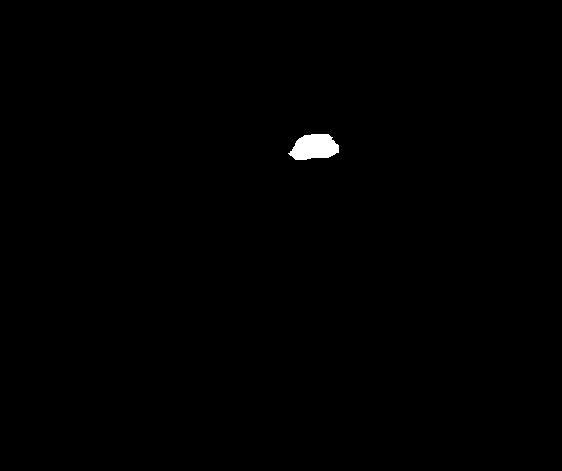

In [32]:
gt
